<a href="https://colab.research.google.com/github/michelli-ofig/DataScience_Em_Producao/blob/main/m09_v01_store_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0. Imports

In [1]:
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.9


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [100]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from flask                 import Flask, request, Response
from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [10]:
def cramer_v (x,y):
    cm= pd.crosstab(x,y).values
    n=cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min( kcorr-1, rcorr-1)))

#Modelos de erro
def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y ,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False):
          mae_list = []
          mape_list= []
          rmse_list= []

          for k in reversed(range(1,kfold+1)):
              if verbose:
                print('\nKfold Number: {}'.format(k))  
              #start and end of validation
              validation_start_date = x_training['date'].max() - timedelta(days=k*6*7)
              validation_end_date = x_training['date'].max() - timedelta(days=k*6*7)

              #filtering dataset 
              training= x_training[x_training['date'] < validation_start_date]
              validation= x_training[ (x_training['date'] >= validation_start_date)  &  (x_training['date'] <= validation_end_date)  ]

              #training and validation
              #training
              xtraining = training.drop(['date','sales'], axis=1)
              ytraining = training['sales']

              #validatiom 
              xvalidation = validation.drop(['date','sales'], axis=1)
              yvalidation = validation['sales']

              #model 
              m = model.fit(xtraining, ytraining)

              #prediction
              yhat =m.predict(xvalidation)

              #performance
              m_result = ml_error(model_name, np.expm1(yvalidation),np.expm1(yhat) ) 
              
              #store performance of eack kfold iteration
              mae_list.append (m_result['MAE'])
              mape_list.append(m_result['MAPE'])
              rmse_list.append(m_result['RMSE'])
          return pd.DataFrame({'Model Name': model_name,
                              'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + '+/-' +  np.round(np.std(mae_list),2).astype(str),
                              'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + '+/-' + np.round(np.std(mape_list),2).astype(str),
                              'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + '+/-' + np.round(np.std(rmse_list),2).astype(str)},index=[0])
            

    
   

## 0.2. Carregando os Dados

In [11]:
df_sales_raw = pd.read_csv('data/train.csv', delimiter= ',', low_memory=False )
df_store_raw = pd.read_csv('data/store.csv', delimiter= ',', low_memory=False )
df_sales_raw.head()





,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [12]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [13]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [14]:
df_raw= pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')



In [15]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [16]:
df_raw=pd.merge(df_sales_raw, df_store_raw, how='left', on= 'Store' )

In [17]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
690682,168,7,2013-10-20,0,0,0,0,0,0,a,a,12540.0,NaN,NaN,0,NaN,NaN,NaN


In [18]:
print(df_raw.shape)

(1017209, 18)


# 1.0 - Descrição dos dados

## 1.0 - Rename Columns

In [19]:
df1=df_raw.copy()

In [20]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [21]:
cols_old= ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'] 

In [22]:
snakecase = lambda x: inflection.underscore(x)  #Função para transformar os dados em snakecase
cols_new = list(map(snakecase, cols_old))

In [23]:
df1.columns = cols_new

In [24]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [25]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of Cols: {}' .format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Type

In [26]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object


## 1.4 Check NA

In [27]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA 

In [28]:
#competition_distance              2642
#competition_open_since_month    323348
#competition_open_since_year     323348
#promo2_since_week               508031
#promo2_since_year               508031
#promo_interval                  508031

In [29]:
#competition_distance 
df1['competition_distance'].max()

75860.0

In [30]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x)else x)

In [31]:
print(df1[df1['competition_distance']==200000.0].shape)

(2642, 18)


In [32]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [33]:
df1['date']= pd.to_datetime(df1['date'])

In [34]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [35]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [37]:
df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x ['competition_open_since_year'], axis=1 )
df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x ['competition_open_since_month']) else x['competition_open_since_month'], axis=1)   

In [38]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )










In [39]:
df1.sample(50).T

,318246,916575,554955,100363,268750,762219,446615,452527,175156,585786,...,753765,14849,83879,899904,543032,246992,166237,849615,859546,467197
store,623,831,471,14,697,345,286,623,102,82,...,811,355,255,885,813,390,103,771,667,798
day_of_week,7,1,3,6,4,6,2,4,2,3,...,7,6,7,2,7,6,3,5,3,5
date,2014-10-05 00:00:00,2013-04-01 00:00:00,2014-02-19 00:00:00,2015-05-02 00:00:00,2014-11-27 00:00:00,2013-08-17 00:00:00,2014-05-27 00:00:00,2014-05-22 00:00:00,2015-02-24 00:00:00,2014-01-22 00:00:00,...,2013-08-25 00:00:00,2015-07-18 00:00:00,2015-05-17 00:00:00,2013-04-16 00:00:00,2014-03-02 00:00:00,2014-12-20 00:00:00,2015-03-04 00:00:00,2013-05-31 00:00:00,2013-05-22 00:00:00,2014-05-09 00:00:00
sales,0,0,7680,4933,12027,3328,4839,6432,4698,9623,...,0,6599,0,3269,0,11719,5279,9656,5833,7957
customers,0,0,574,512,1091,377,477,803,784,890,...,0,805,0,543,0,1073,401,826,606,1057
open,0,0,1,1,1,1,1,1,1,1,...,0,1,0,1,0,1,1,1,1,1
promo,0,0,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,1,0,1
state_holiday,0,b,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
school_holiday,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
store_type,a,a,d,a,d,a,a,a,a,a,...,a,a,c,a,a,a,d,a,d,a


In [40]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [42]:
print(df1['is_promo'].unique() )

[0 1]


In [43]:
print(df1[df1['is_promo']==1].shape)

(157902, 20)


In [44]:
print(df1.shape)

(1017209, 20)


## 1.6 Change dtypes

In [45]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [46]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int64)


In [47]:
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int64)


In [48]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [49]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int64)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int64)


In [50]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descritive Statistical

In [51]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64','datetime64[ns]'])

In [52]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
851318,0,d,a,"Jan,Apr,Jul,Oct",May
397453,0,a,c,"Mar,Jun,Sept,Dec",Jul


### 1.7.1 Numerical Attributes

In [53]:
#Central Tendence - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()  )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T

#concatenate

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['atributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew','kurtosis']
m




,atributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


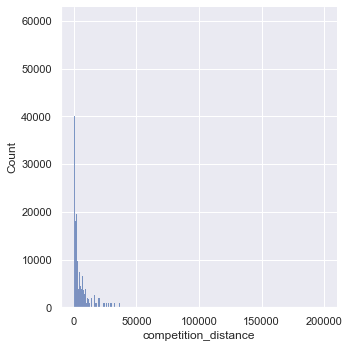

In [54]:
sns.set(rc={'figure.figsize':(30,21.27)})
sns.displot(df1['competition_distance'])


### 1.7.2 Categorical Attributes

In [55]:
cat_attributes.apply(lambda x: x.unique().shape[0]) #Imprime os tipos de cada variável

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

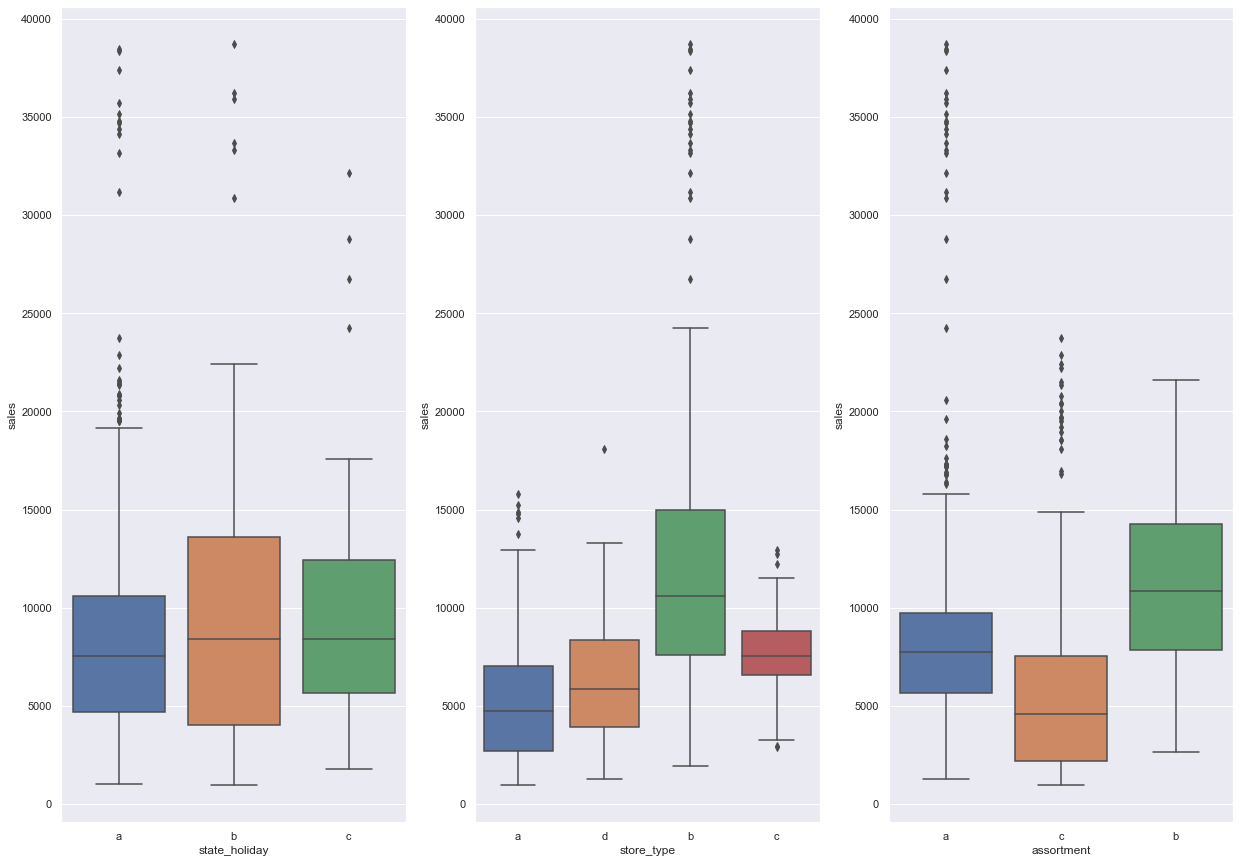

In [58]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0. Feature Engineering

## 2.1 Mapa Mental de Hipóteses

In [59]:
df2 = df1.copy()

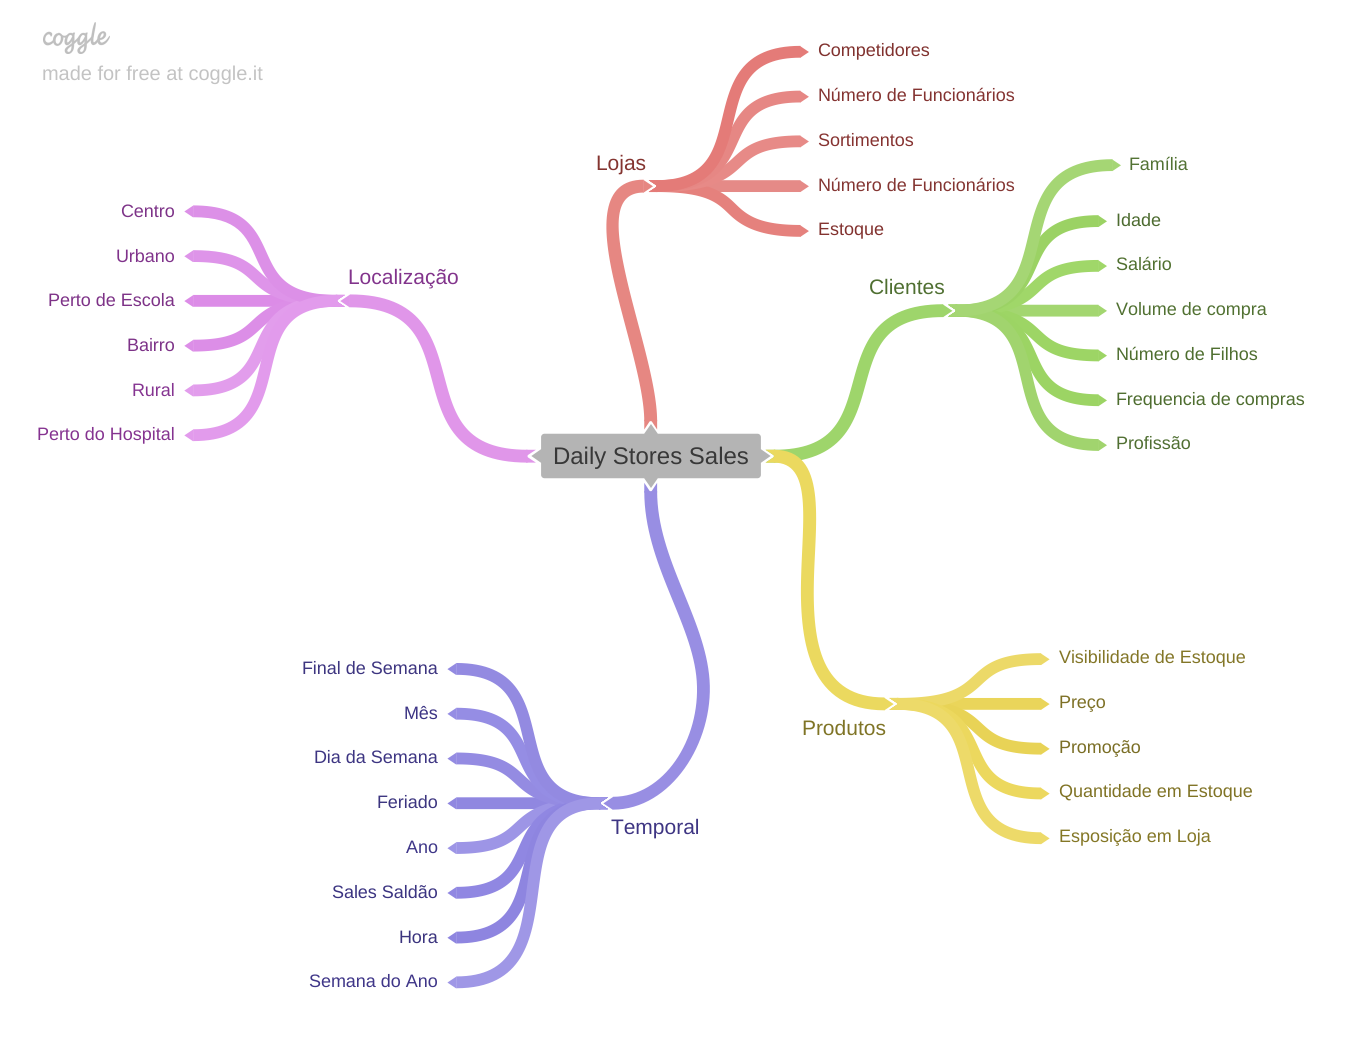

In [60]:
Image('img/MindMapHipothesis.png')


## Criação  das Hipóteses

## 2.1.1 Hipóteses Lojas

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com competidores mais próximos deveriam vender menos.

**5.** Lojas com competidores a mais tempos deveriam vender mais .

**6.** Lojas com maior sortimento deveriam vender mais.

## 2.1.2 Hipóteses Produtos


 **1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõe mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas como promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas como promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais 



## 2.1.3. Hipótese Tempo    


**1.** Lojas abertas durante o feriado do Natal deveriam vender mais.

**2.** Lojas  deveriam vender mais ao longo dos anos.

**3.** Lojas  deveriam vender mais no segundo semestre do ano.

**4.** Lojas  deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas  deveriam vender menos aos final de semana.

**6.** Lojas  deveriam vender menos durante os feriados escolares.

## 2.2 Lista final de Hipóteses

**1.** Lojas com competidores mais próximos deveriam vender menos.

**2.** Lojas com maior sortimento deveriam vender mais.

**3.** Lojas com competidores a mais tempos deveriam vender mais.

**4.** Lojas como promoções mais agressivas (descontos maiores), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais. 

**7.** Lojas abertas durante o feriado do Natal deveriam vender mais.

**8.** Lojas  deveriam vender mais ao longo dos anos.

**9.** Lojas  deveriam vender mais no segundo semestre do ano.

**10.** Lojas  deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas  deveriam vender menos aos finais de semana.

**12.** Lojas  deveriam vender menos durante os feriados escolares.





## 2.3 Feature Enginnering

In [61]:
#year 
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week_of_year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
#df2['week_of_year'] = df2['date'].dt.weekofyear

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y - %W')

# competition_since
df2['competition_since']= df2.apply( lambda x: dt.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month']= ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: dt.datetime.strptime(x + '-1','%Y-%W-%w') - dt.timedelta(days=7))
df2['promo_time_week'] =((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment']= df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state_holiday
df2['state_holiday']=df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')





In [62]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Filtragem de Vendas

In [64]:
df3 = df2.copy()

In [65]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015 - 30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015 - 30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015 - 30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015 - 30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015 - 30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [66]:
df3 = df3[(df3['open']!=0)& (df3['sales']!=0)]

## 3.2. Seleção das Colunas

In [67]:
cols_drop = ['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. Análise Exploratória dos dados

In [68]:
df4 = df3.copy()

In [69]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015 - 30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015 - 30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015 - 30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015 - 30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015 - 30,2015-04-01,4,2015-07-27,0


## 4.1 Análise Univariada

### 4.1.2 Response Variable

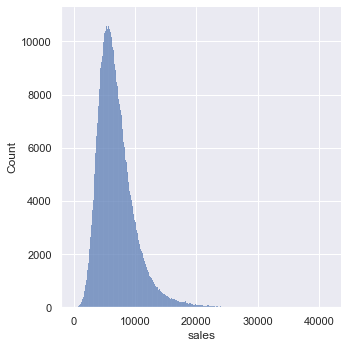

In [70]:
plt.rcParams['figure.figsize'] = (21,30)
sns.displot(df4['sales']);

### 4.1.2 Numerical Variable

In [71]:
cat_attributes.head()

#state_holiday	
#store_type	
#assortment	


,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


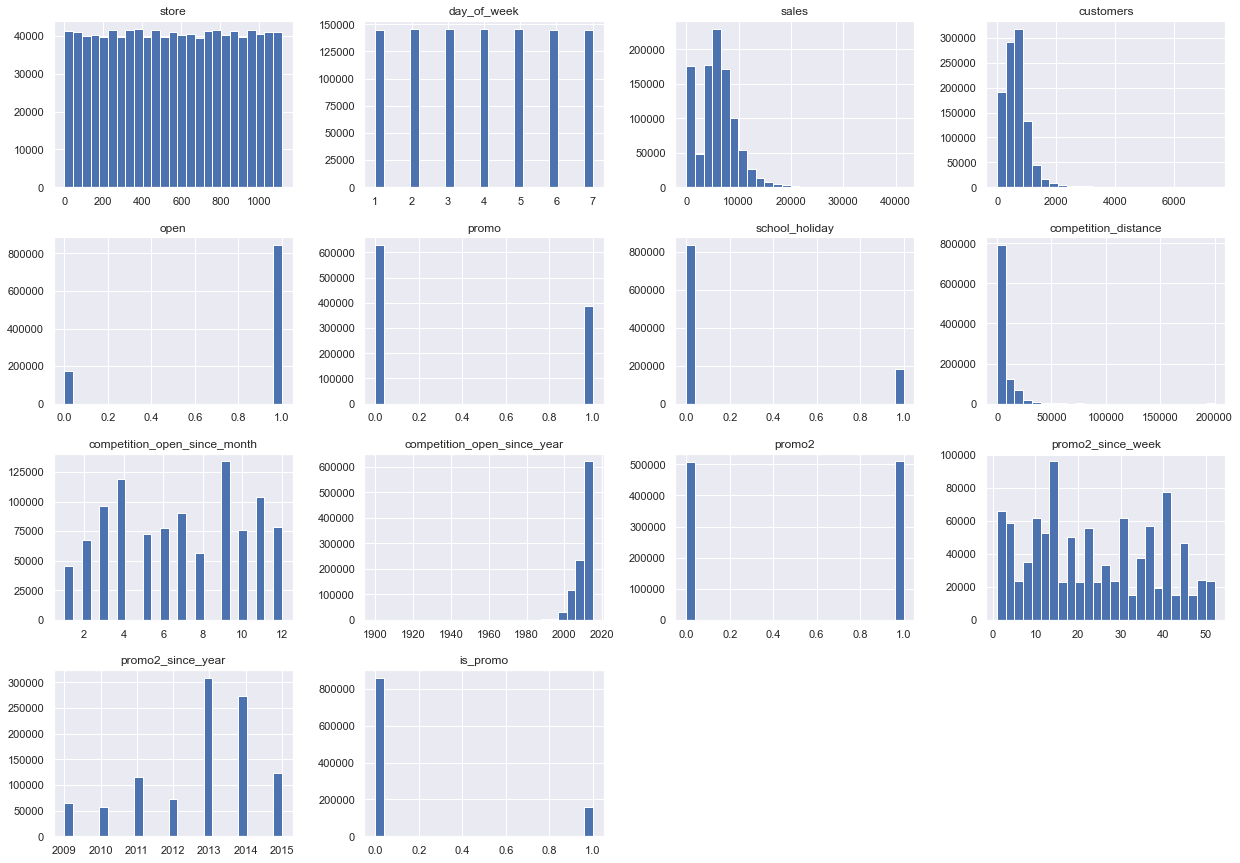

In [72]:
sns.set(rc={'figure.figsize':(21,15)})
num_attributes.hist(bins =25);

### 4.1.3 Categorical Variable

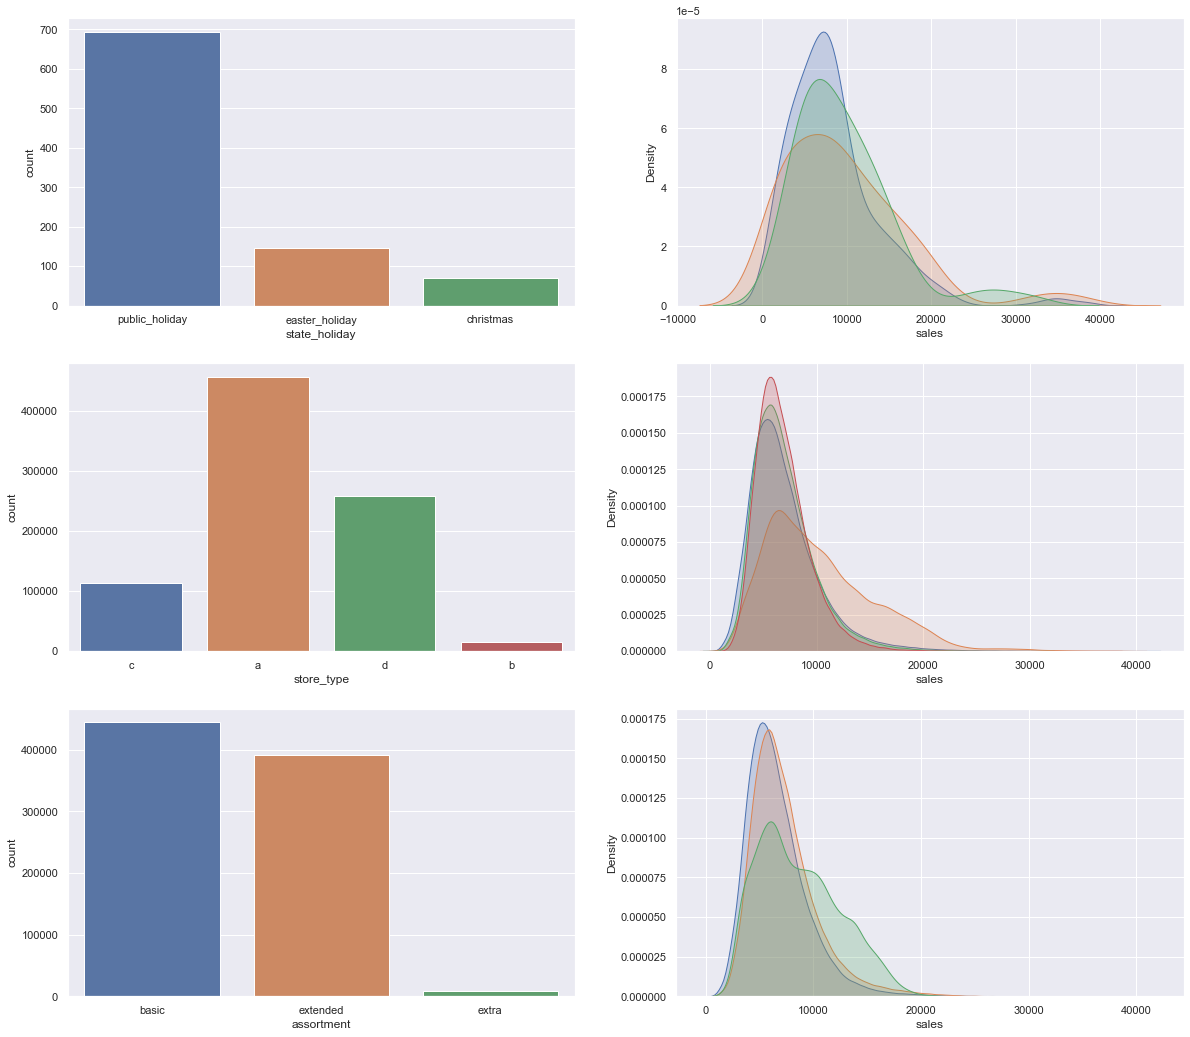

In [73]:
#state_holiday
plt.figure( figsize=(20, 18))
plt.subplot(3,2,1)

a = df4[df4['state_holiday']!= 'regular_day']
sns.countplot(a['state_holiday'])


plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label ='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label ='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label ='christmas', shade=True)

#store_type

plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'],label ='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'],label ='b', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'],label ='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'],label ='d', shade=True);

#assortment

plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'],label ='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'],label ='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'],label ='extra', shade=True);








## 4.2 Análise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais.
***False*** Lojas com MAIOR SORTIMENTO vendem MENOS

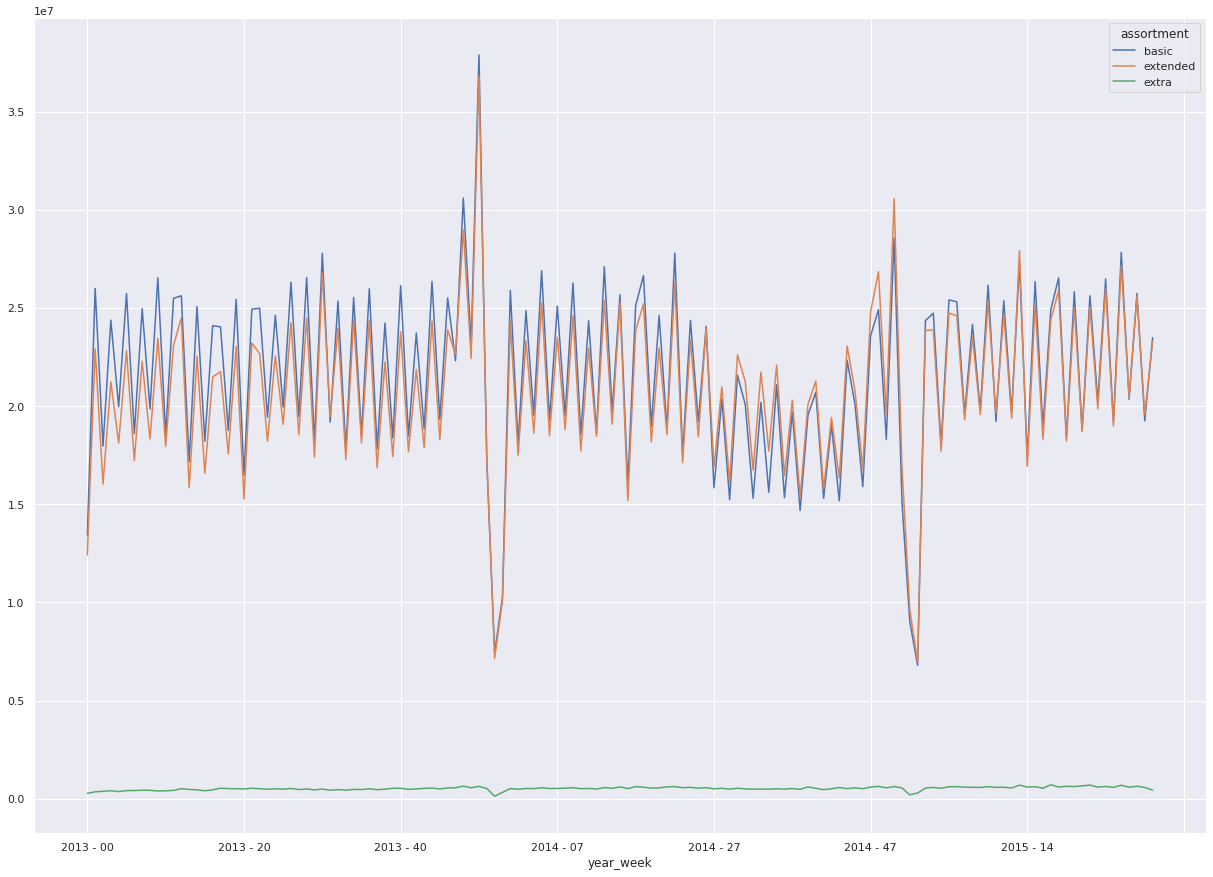

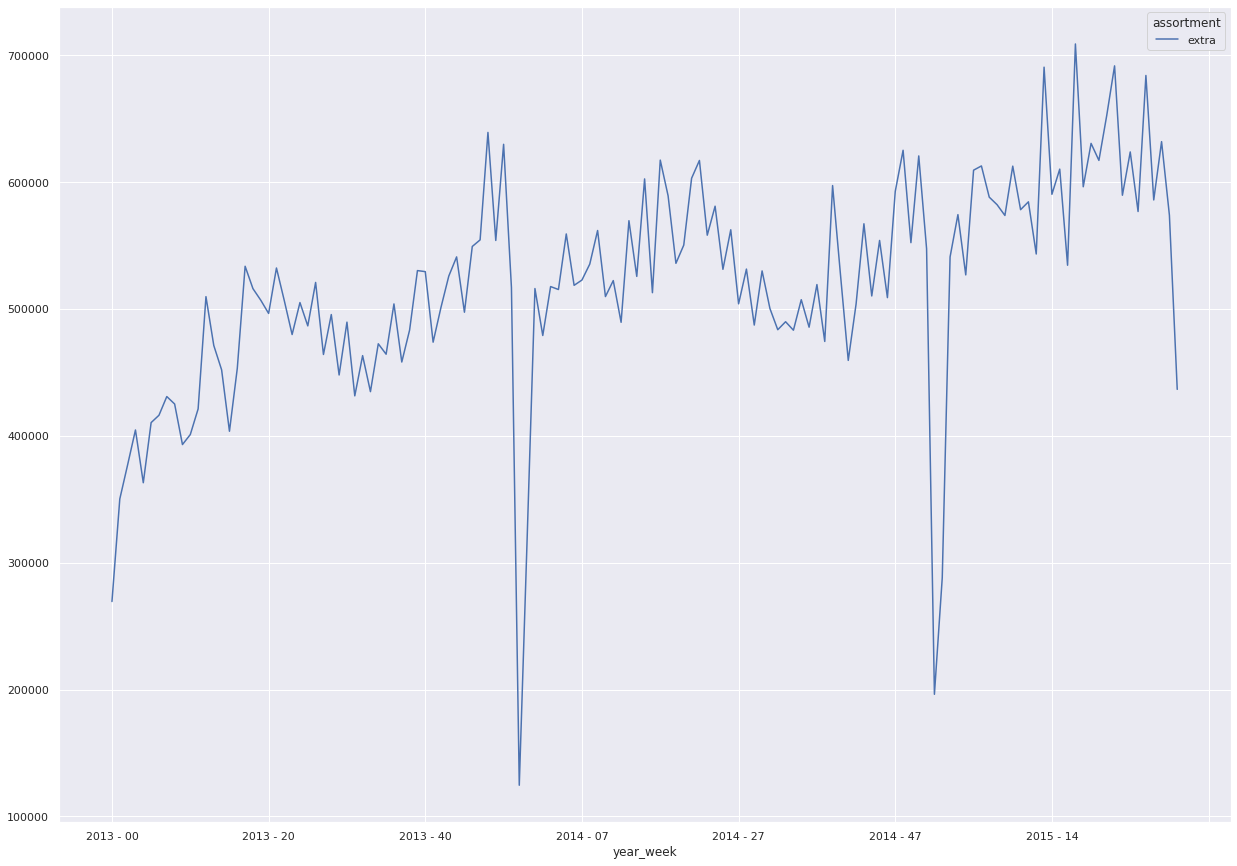

In [71]:
aux1= df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index= 'year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index= 'year_week', columns='assortment', values='sales').plot();

###  H2 - Lojas com competidores mais próximos deveriam vender menos.
**Falsa** Lojas com competidores mais PRÓXIMOS vendem MAIS






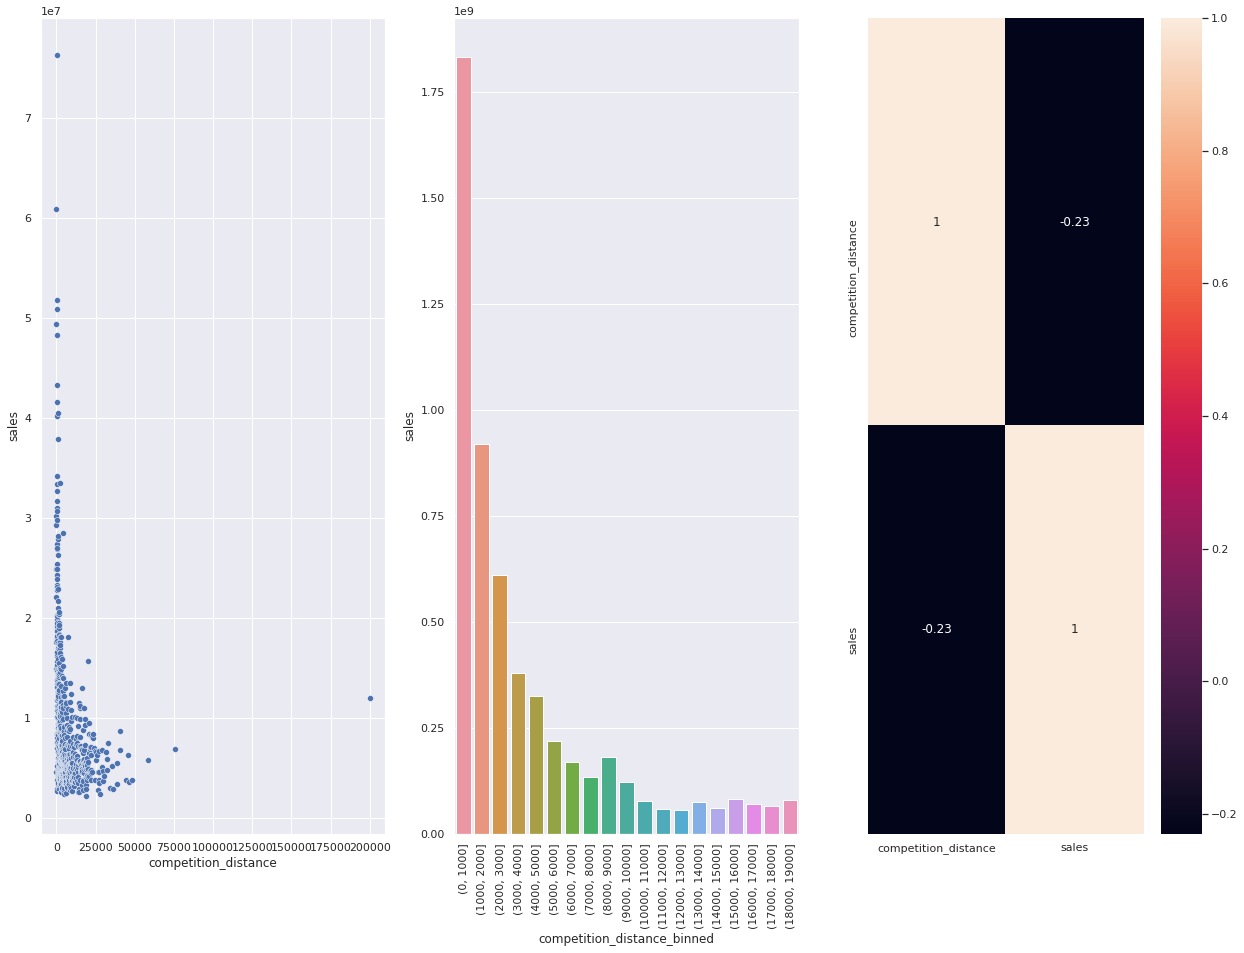

In [72]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x ='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H3. Lojas com competidores a mais tempo deveriam vender mais.
**Falsa** Loja com COMPETIDORES a MAIS TEMPO vende MENOS. 

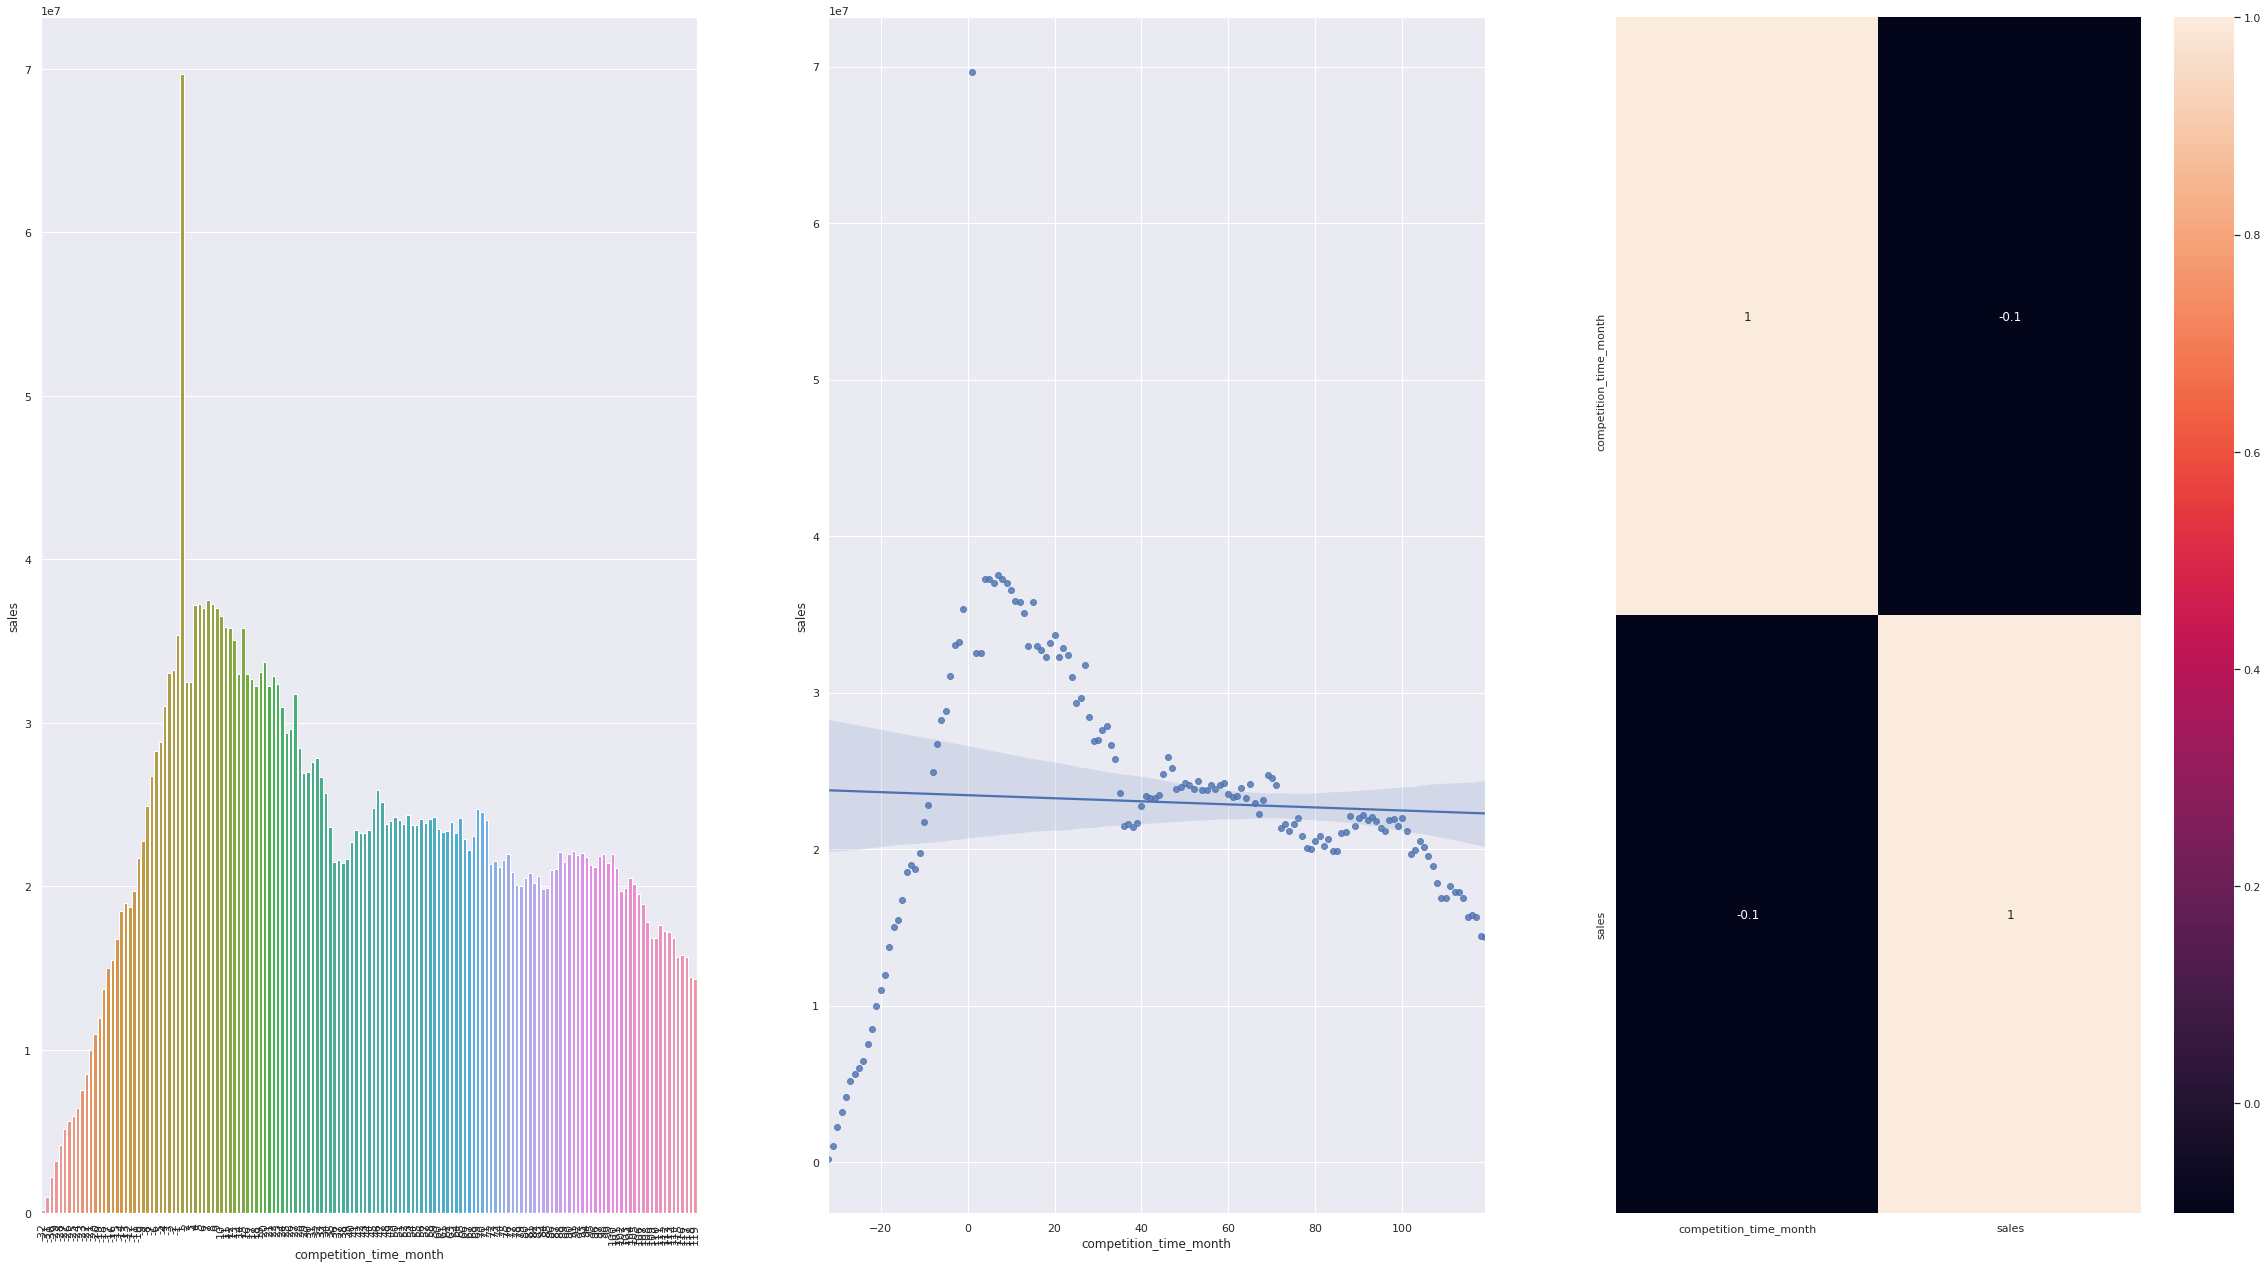

In [73]:
plt.figure( figsize=(40, 22))

plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120)& (aux1['competition_time_month'] !=0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
x=sns.heatmap(aux1.corr(method='pearson'), annot =True)




### **H4.**  Lojas como promoções ativas por mais tempo deveriam vender mais.
**Falsa** Lojas com promoçoes ativas por MAIS TEMPO vendem MENOS, depois de um certo período de promoção.

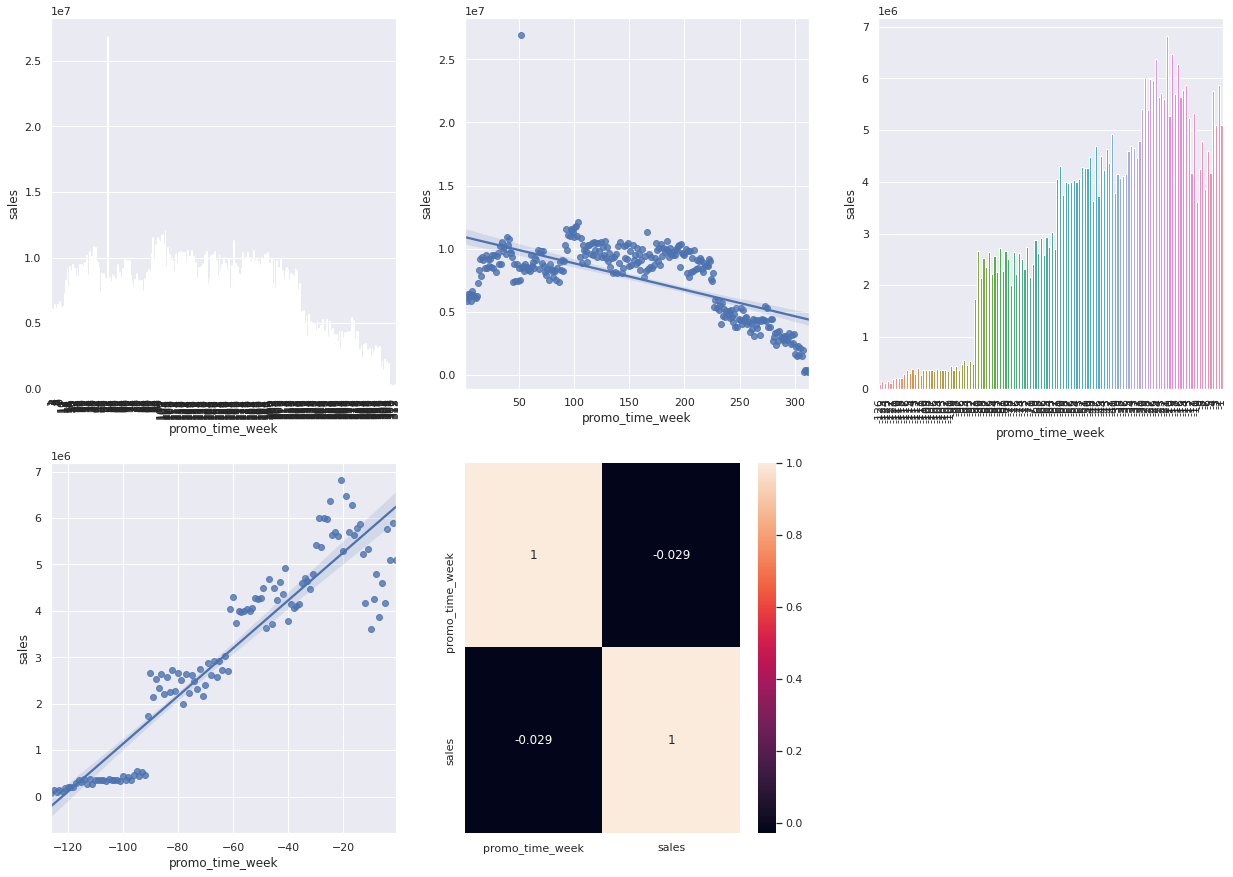

In [74]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.subplot(2,3,1)
aux2 = aux1[aux1['promo_time_week'] > 0]  #promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation =90);

plt.subplot(2,3,2)
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(2,3,3)
aux3 = aux1[aux1['promo_time_week'] < 0]  #promo regular 
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation =90);

plt.subplot(2,3,4)
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(2,3,5)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais </s>


### **H7.** Lojas como promoções consecutivas deveriam vender mais.
**Falsa** Lojas como promoções consecutivas vendem menos.

In [75]:
df4[['promo','promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


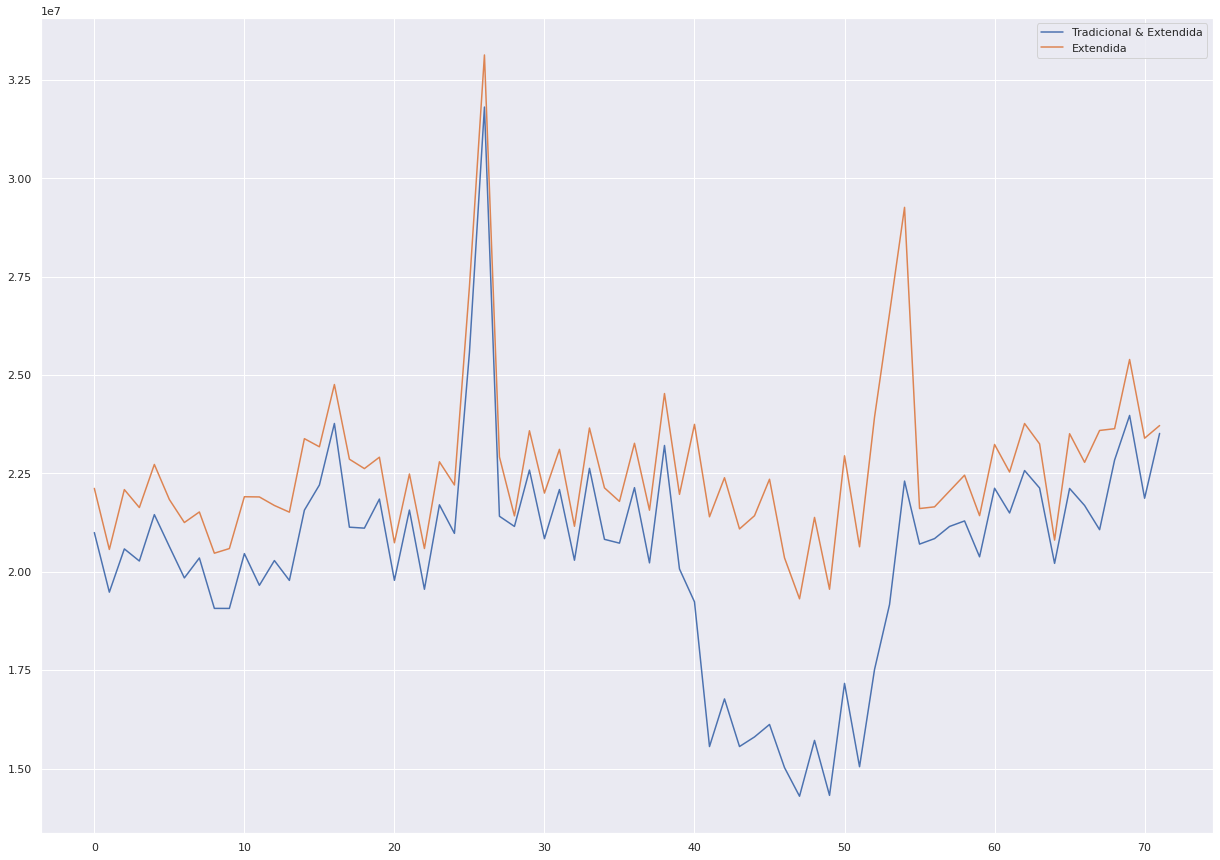

In [76]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida','Extendida']);

### **H8.** Lojas abertas durante o feriado do Natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado do Natal vendem menos.

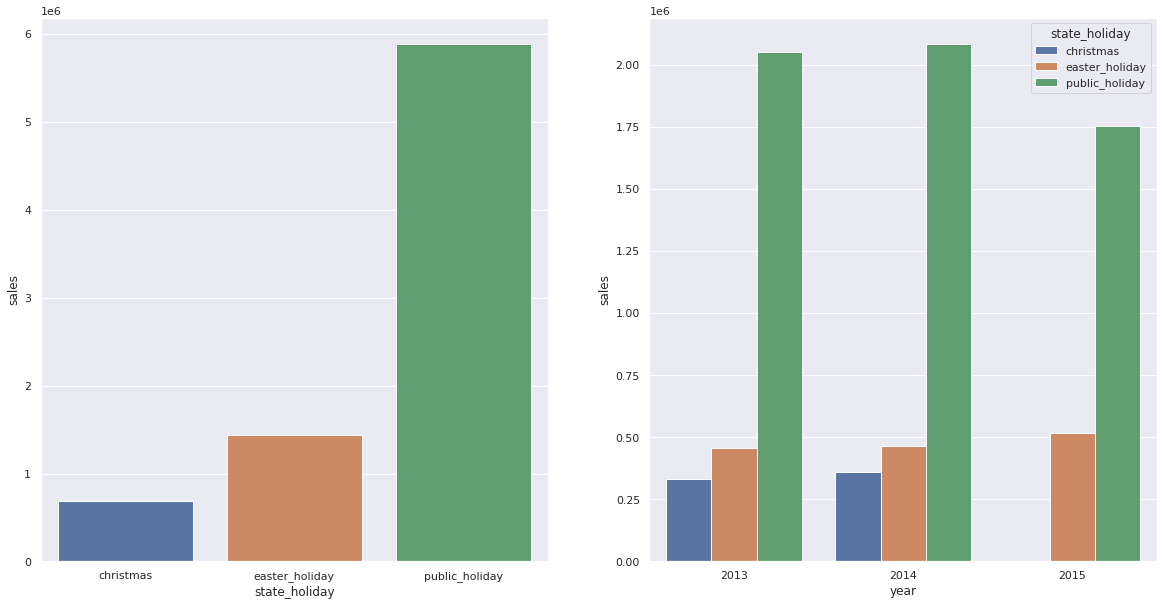

In [77]:
plt.figure( figsize=(20, 10))
aux= df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data = aux1);

plt.subplot(1,2,2)
aux2= aux[['year', 'state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);   

### **H9.** Lojas  deveriam vender mais ao longo dos anos.
**Falsa** As lojas têm vendido menos ao longo dos anos.

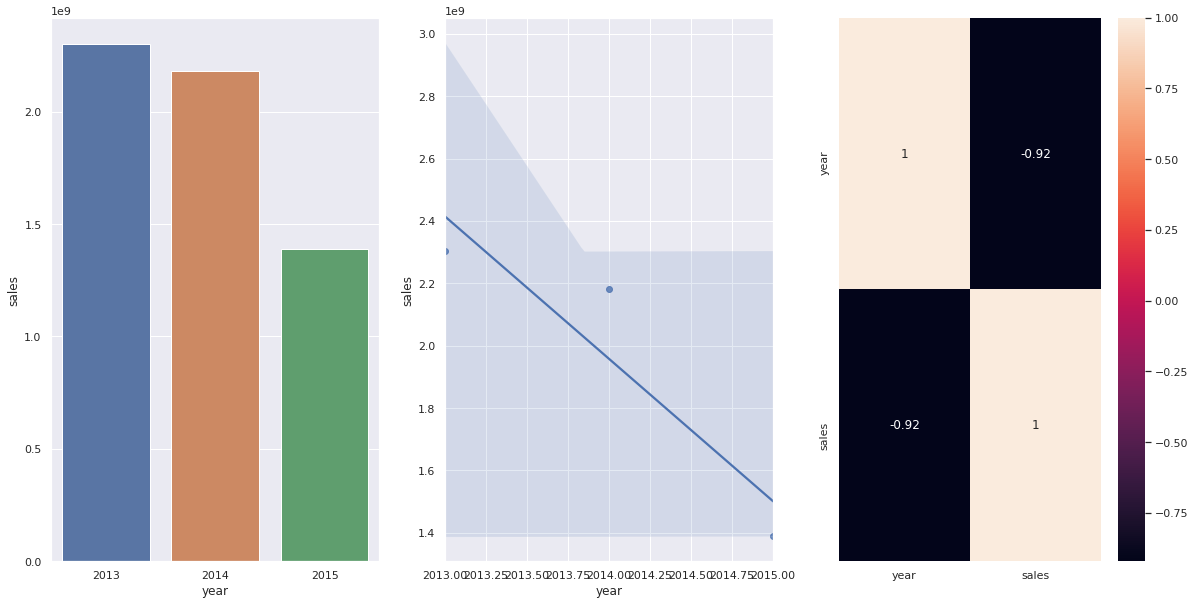

In [78]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
plt.figure( figsize=(20, 10))

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);




### **H10.** Lojas  deveriam vender mais no segundo semestre do ano.
**Falsa** As vendas caem no segundo semestre.

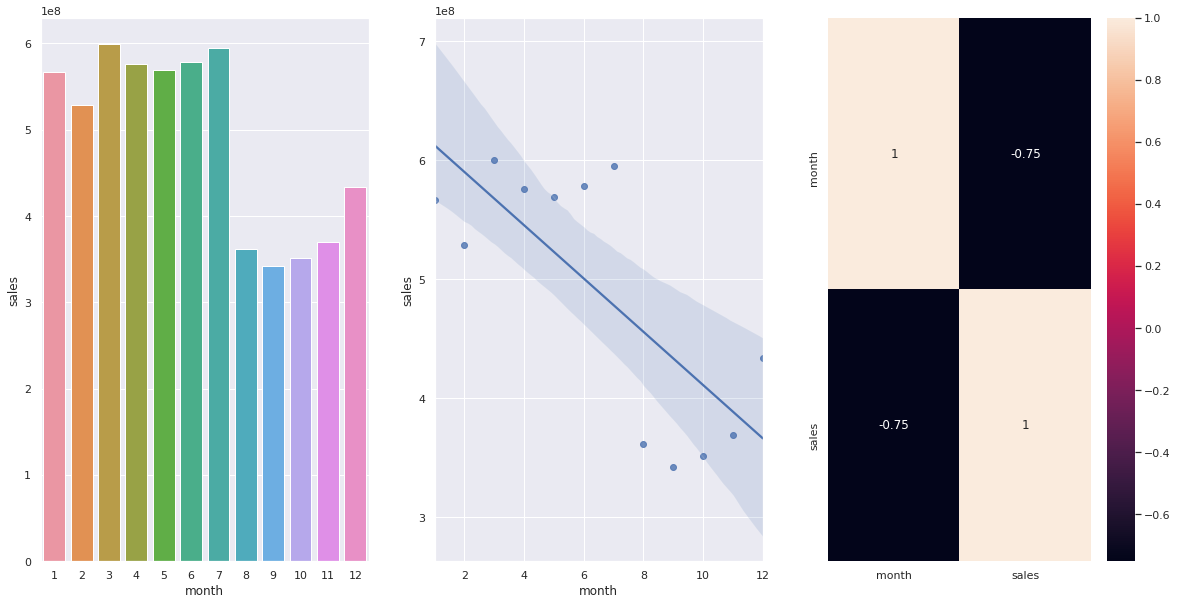

In [79]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
plt.figure( figsize=(20, 10))

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);




### **H11.** Lojas  deveriam vender mais depois do dia 10 de cada mês.
**Verdadeira** Lojas vendem mais depois dia 10

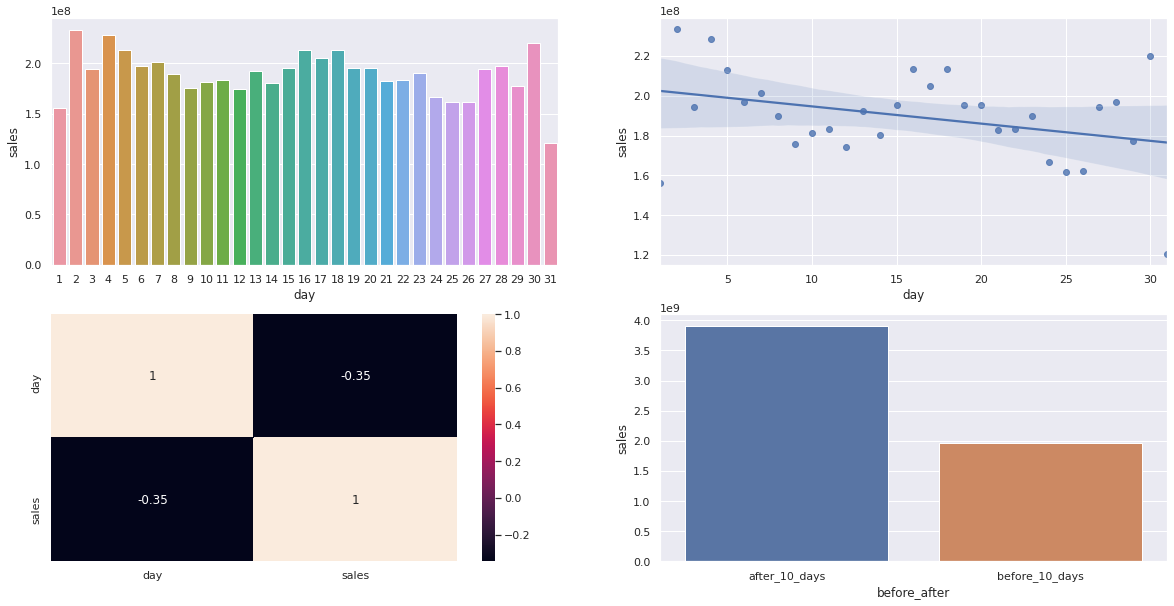

In [80]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.figure( figsize=(20, 10))

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2= aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data= aux2)

### **H12.** Lojas  deveriam vender menos aos finais de semana.
**Falsa** Lojas vendem menos aos finais de semana.


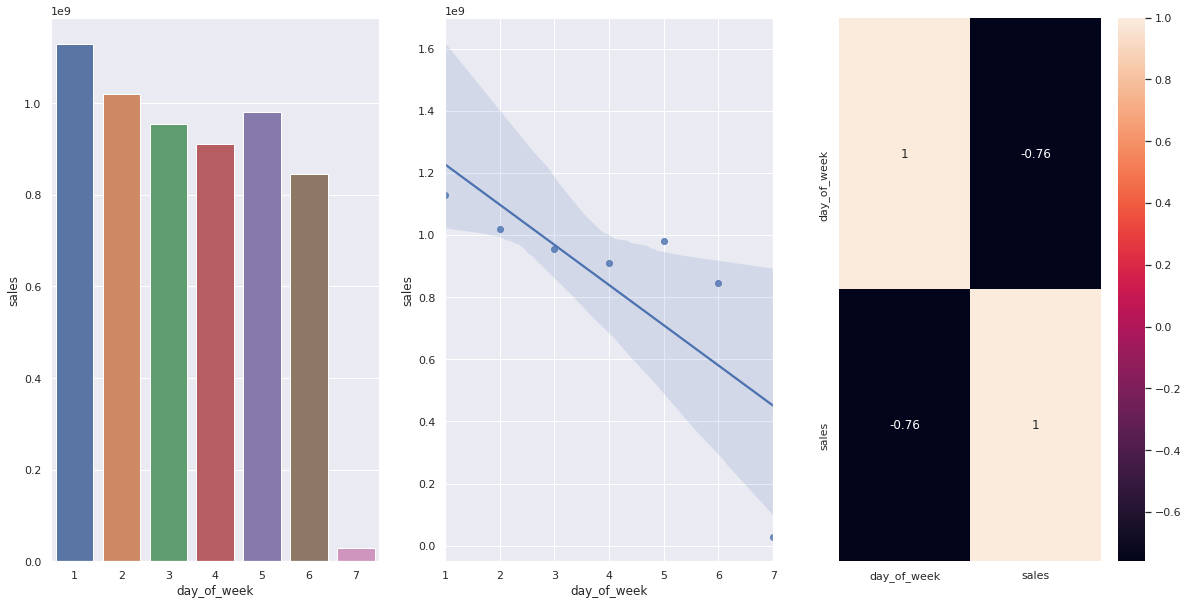

In [81]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.figure( figsize=(20, 10))

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);



### **H13.** Lojas  deveriam vender menos durante os feriados escolares.
**Verdadeira** Lojas vendem menos aos finais de semana, exceto nos meses de julho e agosto.

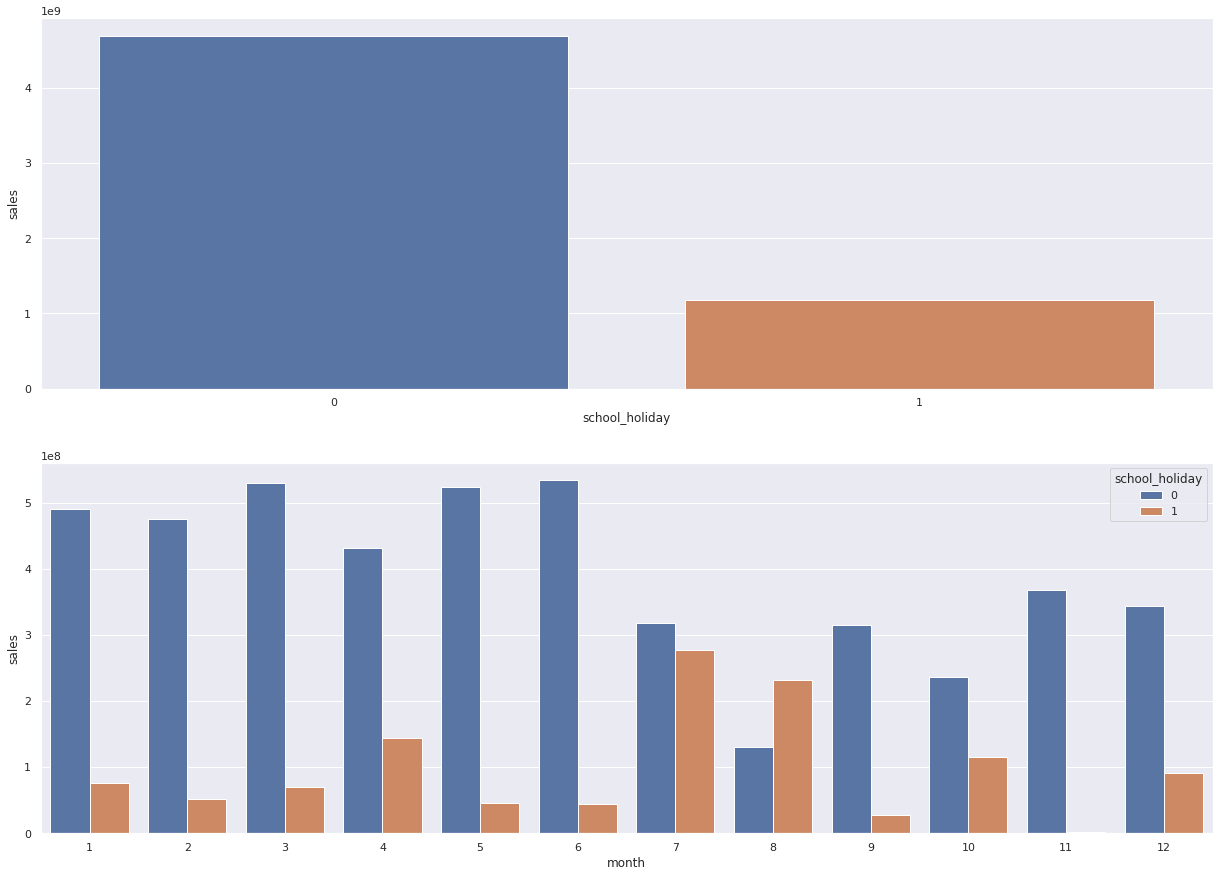

In [82]:
aux1= df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);
aux2 =df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);



### 4.2.1. Resumo da Hipóteses

In [74]:
tab = [['Hipóteses', 'Conclusão', 'Relevãncia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Média'],
['H3', 'Falsa', 'Média'],
['H4', 'Falsa', 'Baixa'],
['H5',   '-',     '-'],
['H6', 'Falsa', 'Baixa'],
['H7', 'Falsa', 'Média'],
['H8', 'Falsa', 'Alta'],
['H9', 'Falsa', 'Alta'],
['H10','Verdadeira', 'Alta'],
['H11','Verdadeira', 'Alta'],
['H12','Verdadeira', 'Baixa'],
]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevãncia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Média
H3           Falsa        Média
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Média
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 - Análise Multivariada 

### 4.3.1. Numerical Attributes

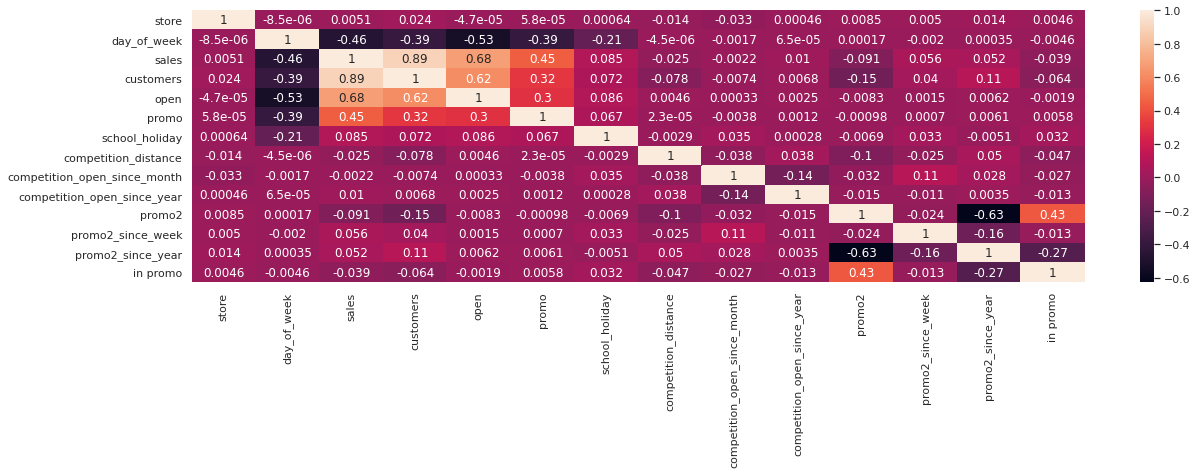

In [84]:
plt.figure( figsize=(20, 5))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2. Categorical Attibutes

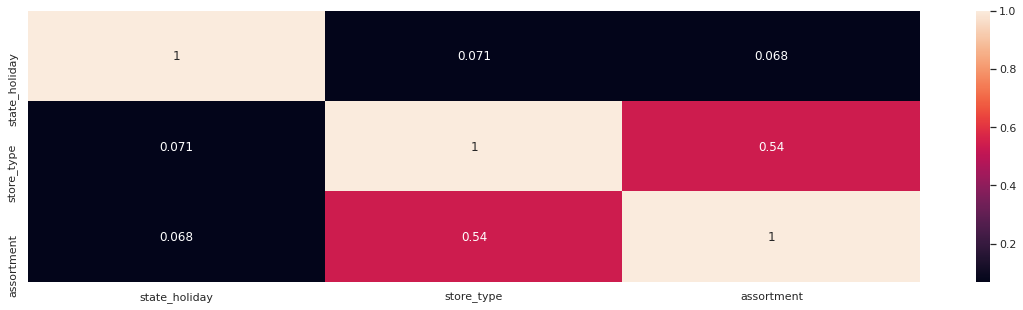

In [85]:
#Only categorical data
a=df4.select_dtypes(include='object')

#Calculante cramer V 
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Final dataset
d = pd.DataFrame({'state_holiday':[a1,a2,a3],
              'store_type':[a4,a5,a6],
              'assortment':[a7,a8,a9], })
d = d.set_index(d.columns)
plt.figure( figsize=(20, 5))
sns.heatmap(d, annot=True);      

# 5.0. Data Preparation

In [75]:
df5= df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [76]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( 'parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb') )

## 5.3. Transformação





## 5.3.1. Encoding

In [77]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [90]:
df5.head()


,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,in promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015 - 30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015 - 30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015 - 30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015 - 30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015 - 30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


## 5.3.2. Response Variable Transformation

In [78]:
df5['sales'] = np.log1p(df5['sales'])

## 5.3.3. Nature Transformation





In [80]:
#day_of_week
df5['day_of_week_sin']= df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7) ) )
df5['day_of_week_cos']= df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7) ) )

#month
df5['month_sin']= df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12) ) )
df5['month_cos']= df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12) ) )

#week_of_year
df5['week_of_year_sin']= df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52) ) )
df5['week_of_year_cos']= df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52) ) )

#day
df5['day_sin']= df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30) ) )
df5['day_cos']= df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30) ) )



# 6.0. Feature Selection

In [81]:
df6=df5.copy()

## 6.1. Split dataframe into training and test dataset


In [82]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [83]:
df6[['store','date']].groupby('store').max().reset_index()['date'] [0] - timedelta(days=6*7) 



Timestamp('2015-06-19 00:00:00')

In [84]:
#Training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test dataset
X_test = df6[df6['date']>= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min() ))
print('Training Max Date: {}'.format(X_train['date'].max() ))

print('\nText Min Date: {}'.format(X_test['date'].min() ))
print('Text Max Date: {}'.format(X_test['date'].max() ))


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Text Min Date: 2015-06-19 00:00:00
Text Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [85]:
#training and test dataset boruta 
X_train_n = X_train.drop(['date', 'sales'], axis=1).values 
y_train_n = y_train.values.ravel()


#define RangdomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#define boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n)

In [100]:
#cols_selected = boruta.support_.tolist()
#best features
#X_train_fs = X_train.drop(['date','sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected ].columns.to_list()

#not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [101]:
#cols_selected_boruta

## 6.3. Manual Feature Selection

In [86]:
cols_selected_boruta = [
  'store',
  'promo',
  'store_type',
  'assortment',
  'competition_distance',
  'competition_open_since_month',
  'competition_open_since_year',
  'promo2',
  'promo2_since_week',
  'promo2_since_year',
  'competition_time_month',
  'promo_time_week',
  'day_of_week_sin',
  'day_of_week_cos',
  'month_sin',
  'month_cos',
  'week_of_year_sin',
  'week_of_year_cos',
  'day_sin',
  'day_cos']

  #columns to add
feat_to_add = ['date','sales']

  #final features 
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)


In [87]:
cols_selected_boruta


['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_sin',
 'day_cos']

# 7.0. Machine Learning Modelling

In [88]:
x_train = X_train[cols_selected_boruta] #Todas as variáveis escolhidas pelo Boruta sem date e sales
x_test = X_test[cols_selected_boruta]

#Time Series Preparation
x_training = X_train[cols_selected_boruta_full] #Todas as variáveis escolhidas pelo Boruta com date e sales


## 7.1. Average Model 

In [105]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction 
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge( aux1,aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance 
baseline_result = ml_error ('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model 


In [106]:
#model 
lr=LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [107]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1856.21+/-581.74,0.29+/-0.05,2696.73+/-929.78


## 7.3. Linear Regression Regularized Model - Lasso

In [108]:
#model 
#lrr=Lasso(alpha=0.01).fit(x_train,y_train)

#prediction
#yhat_lrr = lrr.predict(x_test)

#performance
#lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
#lrr_result

In [109]:
#pickle.dump(lrr_result, open("/content/drive/MyDrive/Colab Notebooks/DataScience_Em_Producao/parameter/lasso.pkl", 'wb'))


In [110]:
ls = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/DataScience_Em_Producao/parameter/lasso.pkl', 'rb'))

In [111]:
ls

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized Model - Cross Validation(Lasso)

In [112]:
#lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
#lrr_result_cv

In [113]:
#pickle.dump(lrr_result_cv, open('/content/drive/MyDrive/Colab Notebooks/DataScience_Em_Producao/parameter/lasso_cv.pkl', 'wb'))


In [115]:
ls_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,1862.95+/-613.96,0.28+/-0.04,2724.38+/-996.31


## 7.4. Random Forest Regressor




In [116]:
#model 
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42 ).fit(x_train,y_train)

#prediction
#yhat_rf = rf.predict(x_test)

#performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
#rf_result

In [117]:
#pickle.dump(rf_result, open("/content/drive/MyDrive/Colab Notebooks/DataScience_Em_Producao/parameter/random_forest.pkl", 'wb'))

In [118]:
rfr = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/DataScience_Em_Producao/parameter/random_forest.pkl', 'rb'))

In [119]:
rfr

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.475278,0.099935,1010.438233


### 7.4.1 Random Forest Regressor - Cross Validation

In [120]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=False)
#rf_result_cv

In [121]:
#pickle.dump(rf_result_cv, open("/content/drive/MyDrive/Colab Notebooks/DataScience_Em_Producao/parameter/random_forest_cv.pkl", 'wb'))

In [122]:
rfr_cv= pickle.load(open('/content/drive/MyDrive/Colab Notebooks/DataScience_Em_Producao/parameter/random_forest_cv.pkl', 'rb'))

In [123]:
rfr_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,581.03+/-264.08,0.11+/-0.05,801.42+/-308.66


## 7.5. XGBoost Regressor

In [124]:
#model 
#model_xgb = xgb.XGBRegressor( objective= 'reg:squarederror',
                              #n_estimators=100,
                              #eta=0.01,
                              #max_depth=10,
                              #colsample_bytree=0.9 ).fit(x_train,y_train)

#prediction
#yhat_xgb = model_xgb.predict(x_test)

#performance
#xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
#xgb_result

In [125]:
#pickle.dump(xgb_result, open("/content/drive/MyDrive/Colab Notebooks/DataScience_Em_Producao/parameter/xgboosty.pkl", 'wb'))

In [126]:
xg_boosty= pickle.load(open('/content/drive/MyDrive/Colab Notebooks/DataScience_Em_Producao/parameter/xgboosty.pkl', 'rb'))

In [127]:
xg_boosty

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,859.98217,0.125001,1264.591144


### 7.5.1 XGBoost Regressor - Cross Validation

In [128]:
#xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#xgb_result_cv

In [129]:
#pickle.dump(xgb_result_cv, open("/content/drive/MyDrive/Colab Notebooks/DataScience_Em_Producao/parameter/xgboosty_cv.pkl", 'wb'))

In [130]:
xg_cv = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/DataScience_Em_Producao/parameter/xgboosty_cv.pkl', 'rb'))

In [131]:
xg_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,841.79+/-330.76,0.15+/-0.07,1201.75+/-455.44


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [132]:
modelling_result = pd.concat([baseline_result, lr_result, ls, rfr, xg_boosty])
modelling_result.sort_values('RMSE')


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.475278,0.099935,1010.438233
0,XGBoost Regressor,859.982170,0.125001,1264.591144
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.6.2 Real Performances - Cross Validation

In [133]:
modelling_result_cv = pd.concat([lr_result_cv, ls_cv, rfr_cv,xg_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1856.21+/-581.74,0.29+/-0.05,2696.73+/-929.78
0,Lasso,1862.95+/-613.96,0.28+/-0.04,2724.38+/-996.31
0,Random Forest Regressor,581.03+/-264.08,0.11+/-0.05,801.42+/-308.66
0,XGBoost Regressor,841.79+/-330.76,0.15+/-0.07,1201.75+/-455.44


# 8.0. Hyperparameter Fine Tuning

## 8.1. Random Search


In [134]:
#param = {
      #'n_estimators': [1500,2700,2000,2500,3000,3500],
      #'eta': [0.01, 0.03],
      #'max_depth': [3,5,9],
      #'subsample': [0.1, 0.5, 0.7],
      #'colsample_bytree': [0.3, 0.7, 0.9],
      #'min_child_weight': [3, 8, 15]}
#MAX_EVAL=5

In [135]:
#final_result=pd.DataFrame()
#for i in range(MAX_EVAL):
  #choose values for parameters randomly
  #hp= {k:random.sample(v,1)[0] for k, v in param.items()}
  #print(hp)

  #model
  #model_xgb = xgb.XGBRegressor( objective= 'reg:squarederror',
                                #n_estimators=hp['n_estimators'],
                                #eta=hp['eta'],
                                #max_depth=hp['max_depth'],
                                #subsample =hp['subsample'],
                                #colsample_bytree =hp['colsample_bytree'],
                                #min_child_weight=hp['min_child_weight'] )
  #performance
  #result = cross_validation(x_training, 5, 'XGBoost Regressor',model_xgb, verbose=False )
  #final_result = pd.concat([final_result, result])
  
  

#final_result
                              



## 8.2.Final Model


In [92]:
param_tuned = {
    'n_estimators': 2700,
    'eta':0.01 ,
    'max_depth':5 ,
    'subsample':  0.7,
    'colsample_bytree': 0.3,
    'min_child_weight': 8}
#'n_estimators': 2700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}

In [1]:
#model
#model_xgb_tuned = xgb.XGBRegressor( objective= 'reg:squarederror',
                                    #n_estimators=param_tuned['n_estimators'],
                                    #eta=param_tuned['eta'],
                                    #max_depth=param_tuned['max_depth'],
                                    #subsample =param_tuned['subsample'],
                                    #colsample_bytree =param_tuned['colsample_bytree'],
                                    #min_child_weight=param_tuned['min_child_weight'] ).fit(x_train,y_train)
#prediction
#yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
#xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test),np.expm1(yhat_xgb_tuned)  )
#xgb_result_tuned

In [95]:
pickle.dump( model_xgb_tuned, open( 'C:/Users/Michelle/repos/DataScience_Em_Producao/model/model_rossmann.pkl', 'wb' ) )

# 9.0. Tradução e Interpretação do Erro

In [163]:
df9=X_test[cols_selected_boruta_full]

#rescale
df9['sales']=np.expm1(df9['sales'])
df9['predictions']=np.expm1(yhat_xgb_tuned)

In [164]:
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,month_sin,month_cos,week_of_year_sin,week_of_year_cos,day_sin,day_cos,date,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148,2015-07-31,5263.0,5903.374512
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148,2015-07-31,6064.0,5488.151367
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148,2015-07-31,8314.0,9900.205078
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148,2015-07-31,13995.0,13180.120117
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.974928,-0.222521,-0.5,-0.866025,-0.568065,-0.822984,0.207912,0.978148,2015-07-31,4822.0,6805.017578


## 9.1.Business Performance

In [170]:
#sum of predictions 
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'] )).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'] )).reset_index().rename(columns={0:'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91,df9_aux3, on='store')

#Scenarios
df92['worst_scenario']=df92['predictions'] - df92['MAE']
df92['best_scenario']=df92['predictions'] + df92['MAE']

#Order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario','MAE','MAPE']]


In [171]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104703.507812,101414.721436,107992.294189,3288.786377,0.539228
908,909,245071.625000,237570.570312,252572.679688,7501.054688,0.520243
875,876,196904.375000,192946.732019,200862.017981,3957.642981,0.284007
1038,1039,356793.156250,354818.323137,358767.989363,1974.833113,0.260604
182,183,199920.843750,198558.512861,201283.174639,1362.330889,0.222972


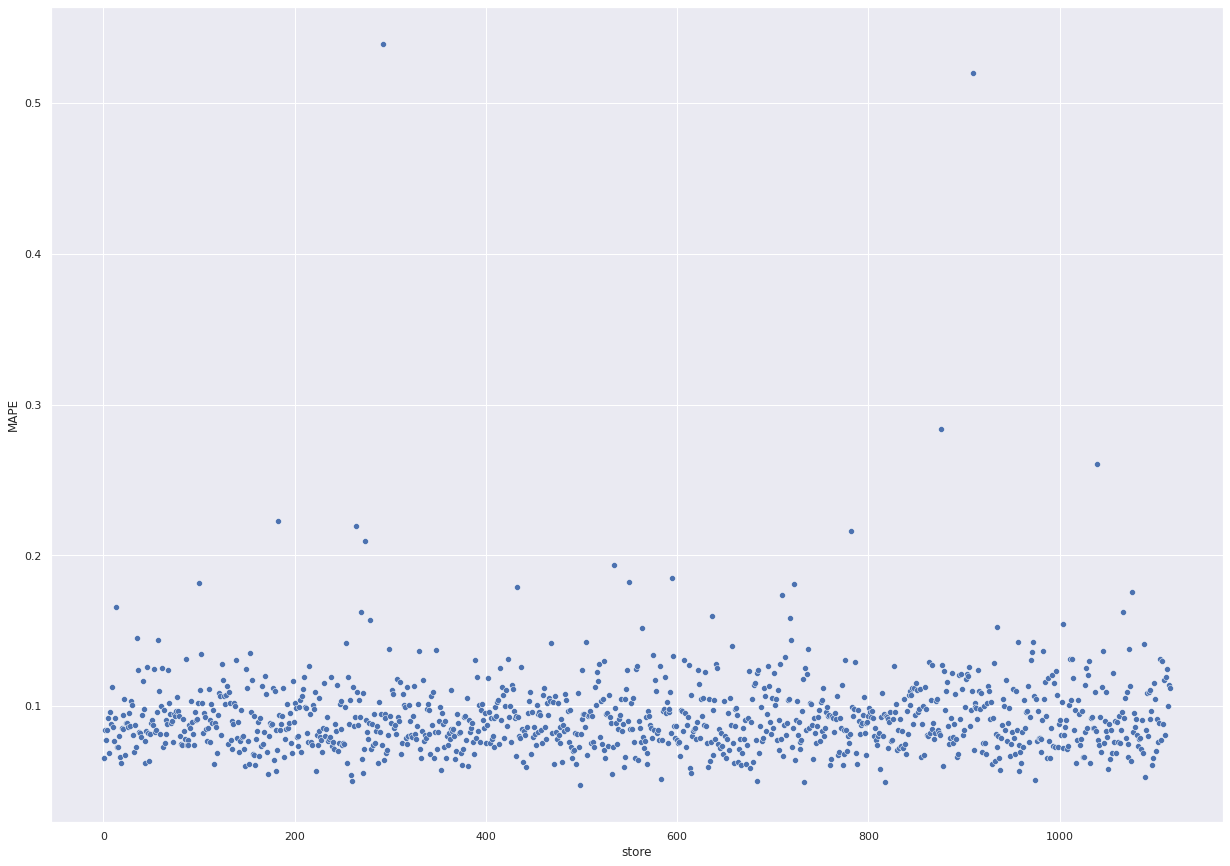

In [172]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2.Total Performance

In [176]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenarios', 0: 'Values'})
df93['Values']=df93['Values'].map( 'R$ {:,.2f}'. format)
df93


,Scenarios,Values
0,predictions,"R$ 282,766,336.00"
1,worst_scenario,"R$ 282,049,070.59"
2,best_scenario,"R$ 283,483,621.22"


## 9.3.Machine Learning 

In [177]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


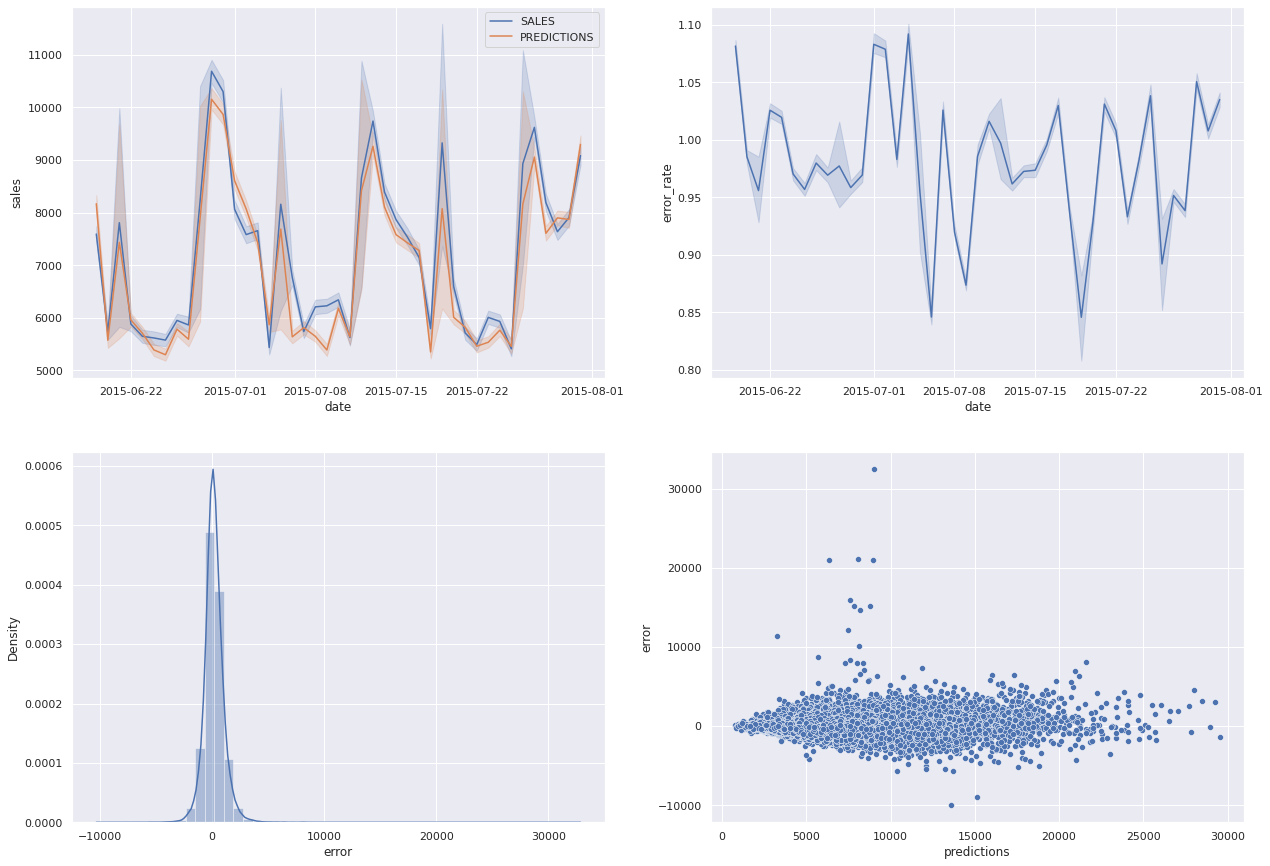

In [180]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'] )





# 10.0. Deploy Model To Production

## 10.1. Rossmann Class

In [105]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='C:/Users/Michelle/repos/DataScience_Em_Producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [106]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( 'C:/Users/Michelle/repos/DataScience_Em_Producao/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )
    #app.run( '127.0.0.1' )

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5000/ (Press CTRL+C to quit)


In [108]:
df10 = pd.read_csv('C:/Users/Michelle/repos/DataScience_Em_Producao/data/test.csv')

In [109]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [110]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )


In [111]:
#Api Call

#url = 'http://127.0.0.1:5000/rossmann/predict' 
url = 'https://rossmann-prediction.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' }
data = data
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 503


In [ ]:
d1=pd.DataFrame(r.json(), columns=r.json()[0].keys())